in this notebook we:
* stage 1a - rescaled images, training from scratch on 384x512 images

In [2]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb import *

In [3]:
%matplotlib inline

In [4]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/1vigjxmw

In [5]:
# PATH_TO_IMG = Path("/data_rescaled")

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [6]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [7]:
len(df.uniqueName)

347120

In [8]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,resc_0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,resc_0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,resc_0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,resc_0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,resc_0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [10]:
%%time
data = get_training_data(df, (384, 512), batch_size=32)#, partial_pct=0.01)

CPU times: user 3.45 s, sys: 236 ms, total: 3.68 s
Wall time: 2.79 s


CPU times: user 4.54 s, sys: 1.22 s, total: 5.76 s
Wall time: 4.47 s


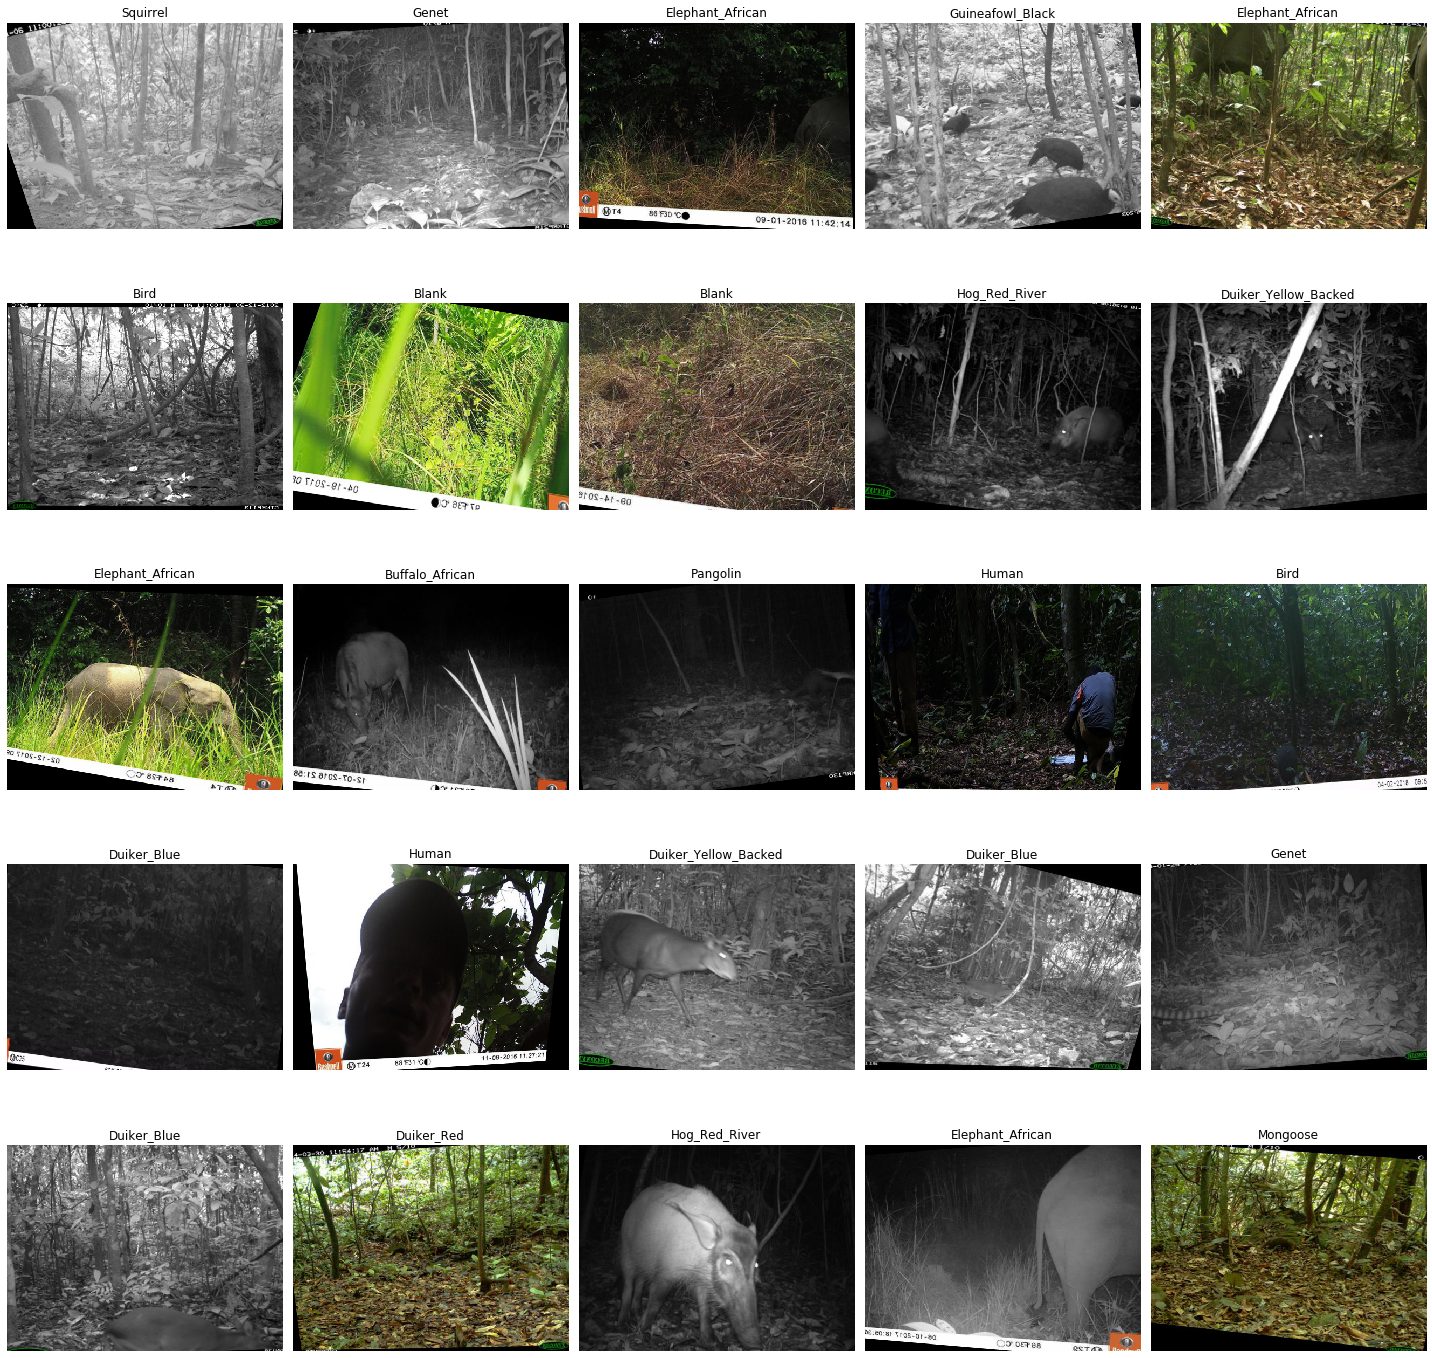

In [10]:
%%time
data.show_batch()

# Stage 1a - learning from scratch

In [11]:
learn = get_initial_learner(data)
# learn.load(PATH_TO_MODELS / "stage5-2epochs-384_512-rescaled");

In [13]:
# learn.unfreeze()

In [12]:
%%time
run_find_lr(learn, "stage1a-5epochs-384_512-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 20.7 s, sys: 8.51 s, total: 29.2 s
Wall time: 57.3 s


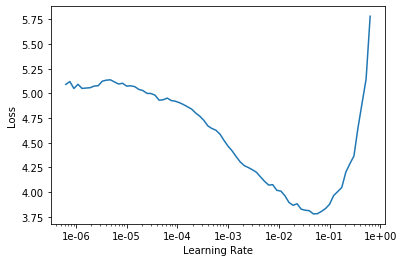

In [13]:
learn.recorder.plot()

In [12]:
lr = 1e-3
n_epochs = 5

In [13]:
# initial_lr = 1e-4 * 5
# lr = 1e-5 / 2
# lr_end = initial_lr / 10
# n_epochs =  5

In [ ]:
%%time
run_training(learn, "stage1a-5epochs-384_512-rescaled", lr=lr, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.764920,1.271651,0.622559,1:02:34
1,0.602224,1.096081,0.692720,1:03:40
2,0.471196,1.024457,0.714610,1:02:51
3,0.420113,1.015707,0.724420,1:04:12


Better model found at epoch 0 with valid_loss value: 1.271651268005371.
Better model found at epoch 1 with valid_loss value: 1.0960813760757446.
Better model found at epoch 2 with valid_loss value: 1.0244567394256592.
Better model found at epoch 3 with valid_loss value: 1.01570725440979.


In [ ]:
learn.recorder.plot_losses()

In [ ]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage1a-5epochs-384_512-rescaled.png")

### Load model and investigate results

In [11]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage1a-5epochs-384_512-rescaled");

In [12]:
# wandb.init(project="gabon")

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

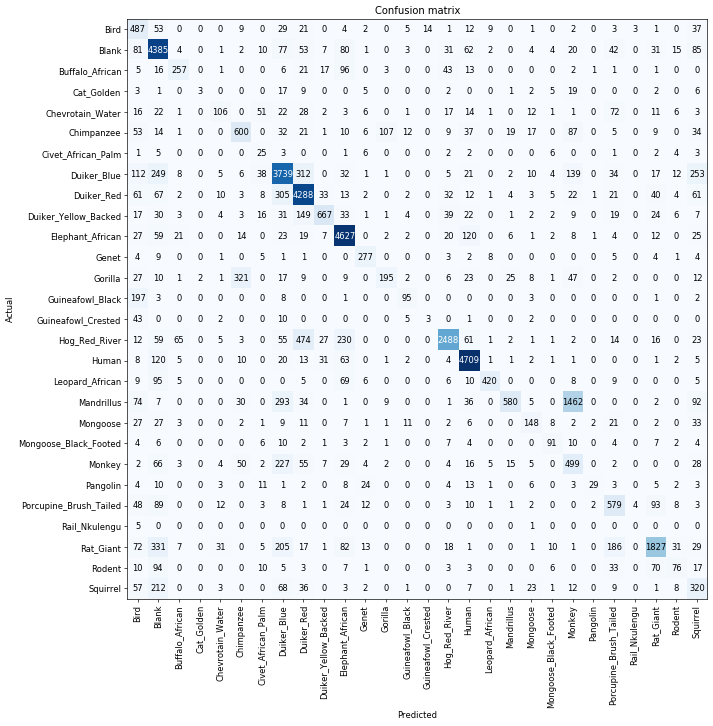

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
conf_m = interp.confusion_matrix()

In [16]:
np.save("conf_m-stage1a-5epochs-384_512-rescaled.npy", conf_m)

In [17]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
all_p = conf_m.sum().sum()
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

accuracy is: 72.25%


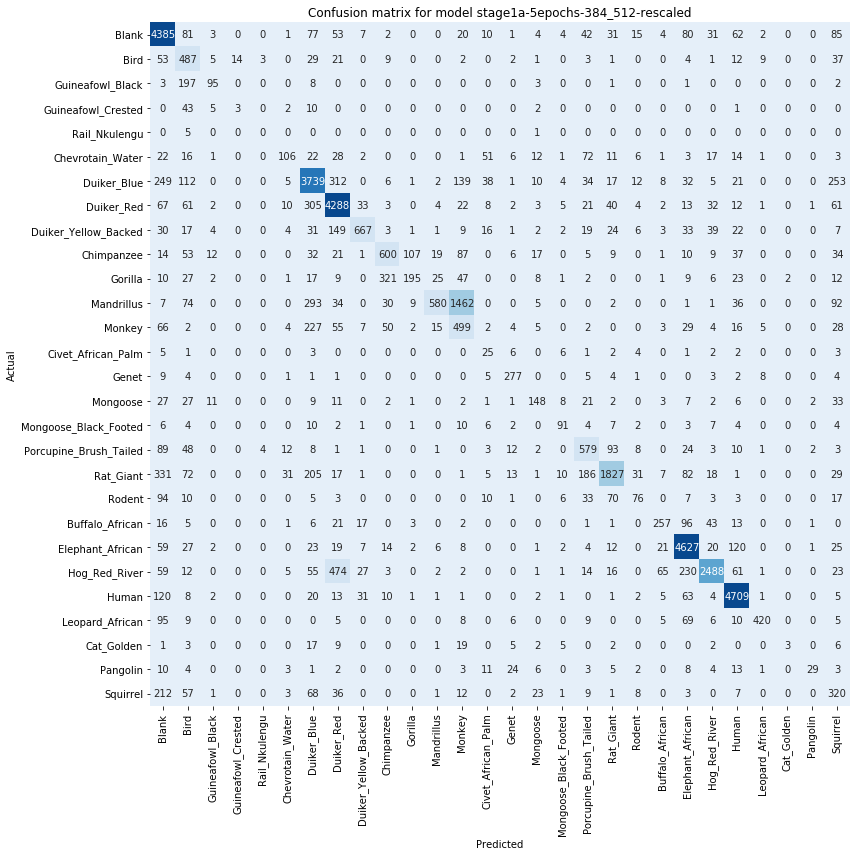

In [18]:
new_order = np.load("new_order.npy")
plot_conf_matrix_reordered(conf_m,
                           sorted(classes),
                           new_order,
                           save_as = "conf_m-new_order-stage1a-5epochs-384_512-rescaled.png", 
                           for_model = "stage1a-5epochs-384_512-rescaled")

In [19]:
preds = learn.get_preds(with_loss=True)

In [20]:
torch.save(preds, "preds-stage1a-5epochs-384_512-rescaled.pt")

In [21]:
preds

[tensor([[2.1978e-06, 5.9115e-06, 4.9134e-04,  ..., 1.2915e-06, 5.2509e-07,
          2.5240e-07],
         [5.2926e-05, 1.6750e-03, 5.6999e-04,  ..., 1.4846e-02, 5.0227e-04,
          3.0001e-05],
         [4.8075e-08, 9.9658e-01, 1.2141e-05,  ..., 1.7683e-07, 6.1617e-07,
          8.1157e-08],
         ...,
         [6.0398e-05, 1.8185e-05, 3.1281e-05,  ..., 2.3290e-05, 1.2208e-05,
          4.2329e-05],
         [1.5609e-01, 4.8582e-03, 4.2076e-04,  ..., 6.0535e-04, 4.9196e-04,
          2.0709e-01],
         [3.8918e-05, 1.7943e-05, 6.7274e-07,  ..., 1.0738e-07, 5.1154e-06,
          1.4214e-03]]),
 tensor([16, 23,  1,  ...,  9, 27, 18]),
 tensor([0.0823, 0.3914, 0.0034,  ..., 0.0087, 1.5746, 2.3643])]

In [32]:
images_list = data.valid_ds.items

In [34]:
np.save("images_list-stage1a-5epochs-384_512-rescaled.pt", images_list)

In [35]:
data.classes

['Bird',
 'Blank',
 'Buffalo_African',
 'Cat_Golden',
 'Chevrotain_Water',
 'Chimpanzee',
 'Civet_African_Palm',
 'Duiker_Blue',
 'Duiker_Red',
 'Duiker_Yellow_Backed',
 'Elephant_African',
 'Genet',
 'Gorilla',
 'Guineafowl_Black',
 'Guineafowl_Crested',
 'Hog_Red_River',
 'Human',
 'Leopard_African',
 'Mandrillus',
 'Mongoose',
 'Mongoose_Black_Footed',
 'Monkey',
 'Pangolin',
 'Porcupine_Brush_Tailed',
 'Rail_Nkulengu',
 'Rat_Giant',
 'Rodent',
 'Squirrel']